In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [6]:
from resources.conv_learner import *
PATH = "datasets/yeast_v2/"
os.makedirs(PATH,exist_ok=True)

In [7]:
classes = ('WT', 'mfb1KO')
stats = (np.array([0.02171638, 0.00451]), np.array([0.0016155,  0.00146062])) #calculated for yeast_v2
# stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

In [8]:
def get_data(sz,bs):
#     tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8)
    tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomDihedral()], pad=sz//8) #even without transformations and padding -> failure
    return ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)

### the eventual sub-function of ImageClassifierData (read_dirs) expects subdirectories for each class: 
### e.g. all "test/cat.png" images should be in a "cat" folder. 

In [9]:
bs=140

In [10]:
data = get_data(200,4)

In [11]:
x,y=next(iter(data.trn_dl))

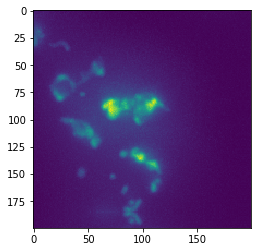

In [12]:
plt.imshow(data.trn_ds.denorm(x)[3,:,:,1]); #denorm function called has a rollaxis() hence indexing changes.

In [13]:
lr=1e-5

In [14]:
class ConvNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(layers[i], layers[i + 1], kernel_size=3, stride=2)
            for i in range(len(layers) - 1)])
        self.pool = nn.AdaptiveMaxPool2d(1)
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = F.relu(l(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [15]:
learn = ConvLearner.from_model_data(ConvNet([2, 20, 40, 80], 2), data)

In [16]:
learn.summary() ### learner.summary is hardcording the number of channels = 3

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 2, 200, 200]),
                           ('output_shape', [-1, 20, 99, 99]),
                           ('trainable', True),
                           ('nb_params', 380)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 20, 99, 99]),
                           ('output_shape', [-1, 40, 49, 49]),
                           ('trainable', True),
                           ('nb_params', 7240)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 40, 49, 49]),
                           ('output_shape', [-1, 80, 24, 24]),
                           ('trainable', True),
                           ('nb_params', 28880)])),
             ('AdaptiveMaxPool2d-4',
              OrderedDict([('input_shape', [-1, 80, 24, 24]),
                           ('output_shape', [-1, 80, 1, 1]),
                           ('nb_params', 0)])),
             ('Linear-5',
              O

In [ ]:
%time learn.fit(lr, 10, cycle_len=1)

In [ ]:
class Resnet2(nn.Module):
    def __init__(self, layers, c, p=0.5):
        super().__init__()
        self.conv1 = BnLayer(3, 16, stride=1, kernel_size=7)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        self.drop = nn.Dropout(p)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        return F.log_softmax(self.out(x), dim=-1)